# Marc Toneatto / met414
# HW10_Assignment2 - Spatial Data Analysis: Winter-Summer Comparison
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from matplotlib import colors
import os
from geopandas import GeoDataFrame
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
shape_path = "CT_SHAPE/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [5]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

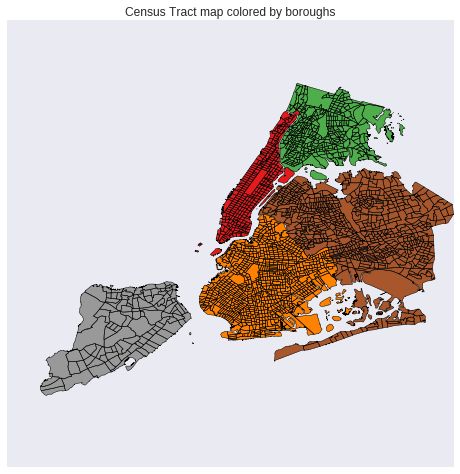

In [7]:
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [8]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [9]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


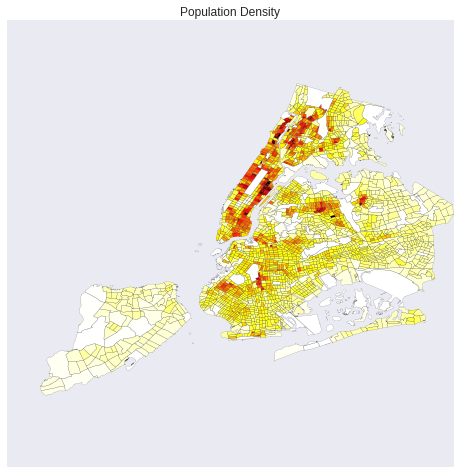

In [10]:
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [11]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Creating a new dataframe for the Summer block: April through September
df_bike_summer = df_bike_monthly.iloc[[0,1,2,9,10,11,12,13,14,21,22,23,24,25,26,33,34,35], :]
df_bike_summer.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2014-04-30,1319,2315,7056,2371,4479,2266,1417,3288,3000,1540,...,0,0,0,0,0,0,0,0,0,0
2014-05-31,1696,3125,9070,3115,6207,2897,2049,3579,3863,2062,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Creating a new dataframe for the Winter block: October through March
df_bike_winter = df_bike_monthly.iloc[[3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32], :]
df_bike_winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0


## Time Series Analysis: ALL MONTHS

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

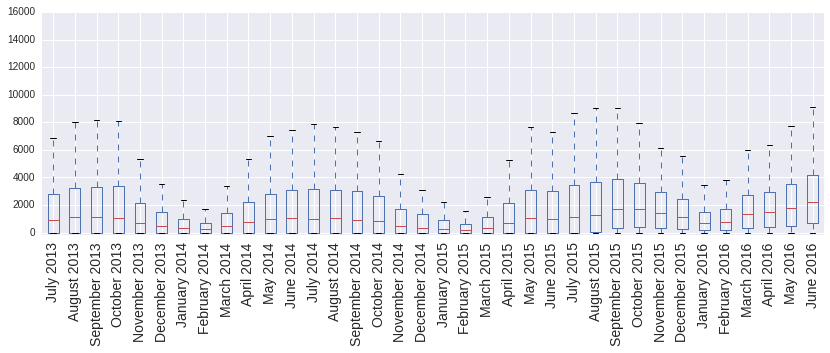

In [20]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

## Time Series Analysis: Summer

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

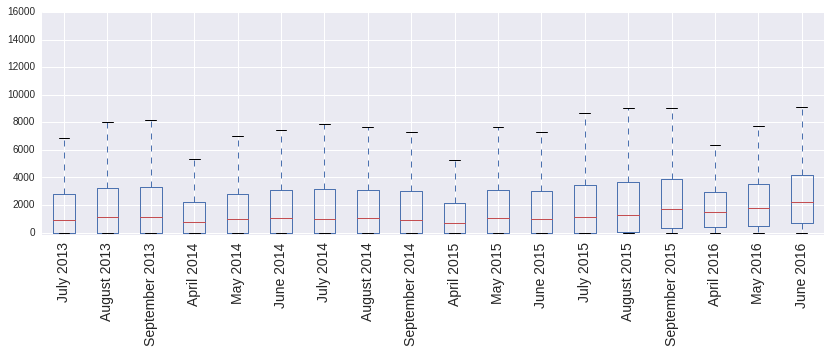

In [18]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

## Time Series Analysis Winter

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

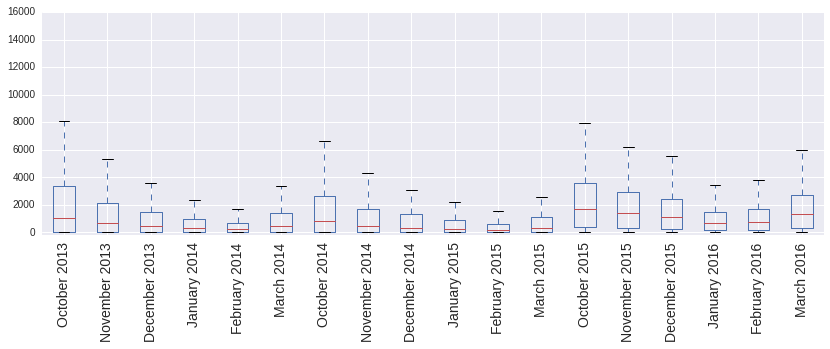

In [19]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

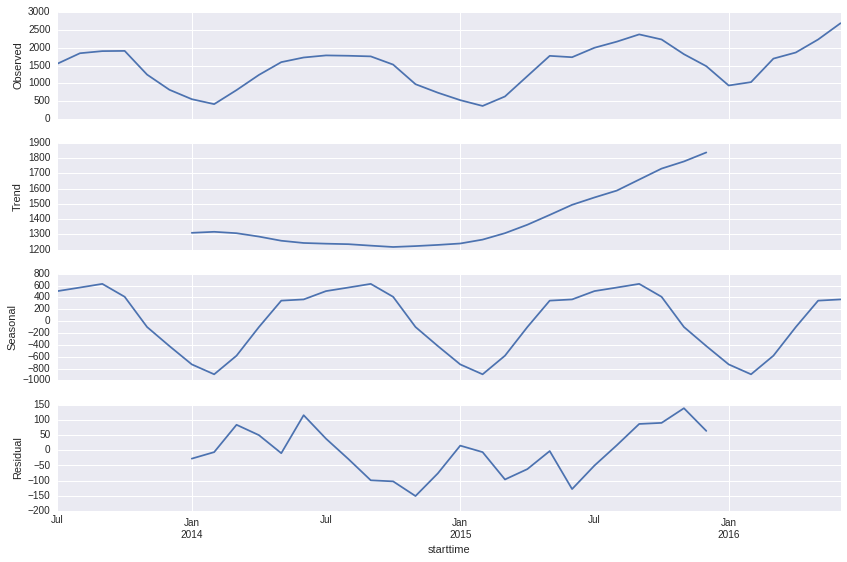

In [21]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [23]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [24]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [25]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [26]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

### SUMMER Average Monthly Rides

In [27]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAVGSummer']=df_bike_summer.sum()

In [28]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAVGSummer
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,42378
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,67646
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,169085
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,64084
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,116324


### WINTER Average Monthly Rides

In [29]:
station_id['MonthlyAVGWinter']=df_bike_winter.sum()
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAVGSummer,MonthlyAVGWinter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,42378,26930
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,67646,35178
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,169085,104440
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,64084,37865
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,116324,67720


### Add the monthly average rides to the CT shapefile 

In [30]:
temp1 = station_id[['MonthlyAVGSummer']]
temp1['station_id'] = station_id.index
temp1.index = station_id['BoroCT2010']
ct_shape_MonthlyAVGSummer = ct_shape.join(temp1)
ct_shape_MonthlyAVGSummer.fillna(0,inplace=True)

temp2 = station_id[['MonthlyAVGWinter']]
temp2['station_id'] = station_id.index
temp2.index = station_id['BoroCT2010']
ct_shape_MonthlyAVGWinter = ct_shape.join(temp2)
ct_shape_MonthlyAVGWinter.fillna(0,inplace=True)


/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


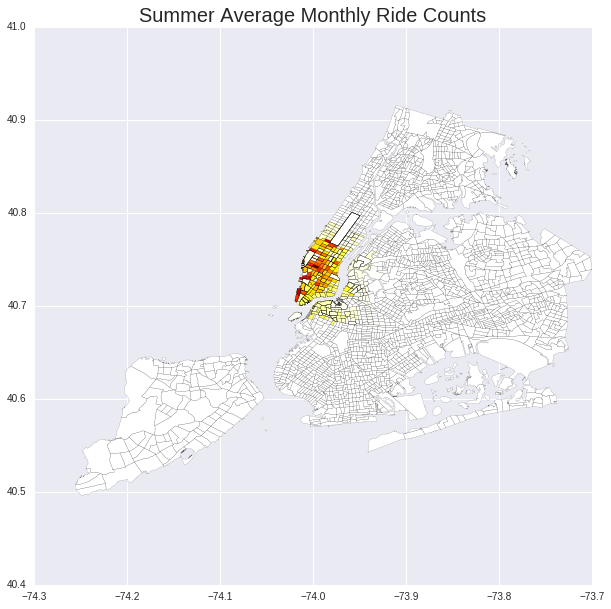

In [34]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAVGSummer.plot(column='MonthlyAVGSummer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Average Monthly Ride Counts", fontsize=20)

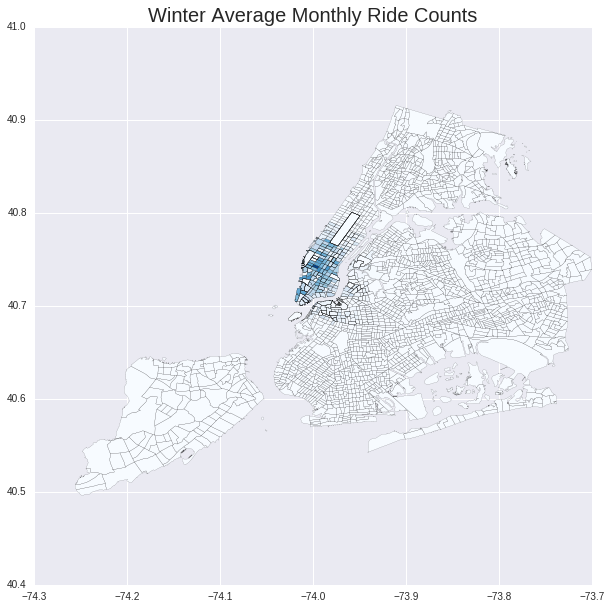

In [76]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAVGWinter.plot(column='MonthlyAVGWinter',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Average Monthly Ride Counts", fontsize=20)

### Removing the CTs that are out of zoom boundries

In [36]:
ct_shape_MonthlyAVGSummer_Zoom=(ct_shape_MonthlyAVGSummer[ct_shape_MonthlyAVGSummer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [37]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp1.MonthlyAVGSummer)

Total number of CTs: 2166
Number of zoomed CTs: 543


In [38]:
ct_shape_MonthlyAVGWinter_Zoom=(ct_shape_MonthlyAVGWinter[ct_shape_MonthlyAVGWinter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [39]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp2.MonthlyAVGWinter)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly ride counts by season

### SUMMER

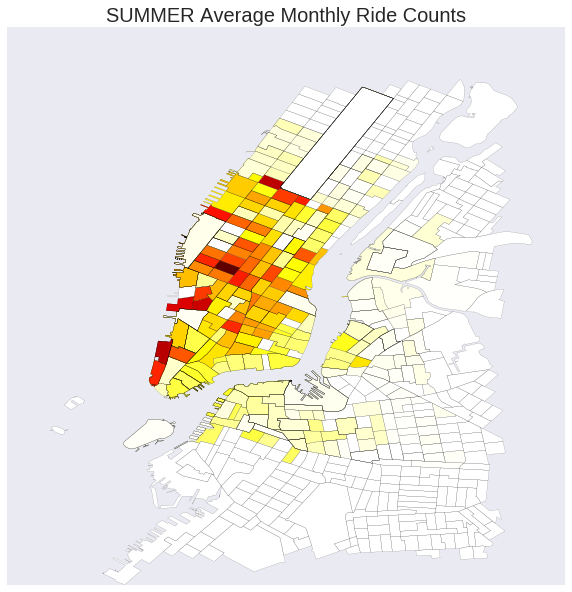

In [40]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAVGSummer_Zoom.plot(column='MonthlyAVGSummer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("SUMMER Average Monthly Ride Counts", fontsize=20)

### WINTER

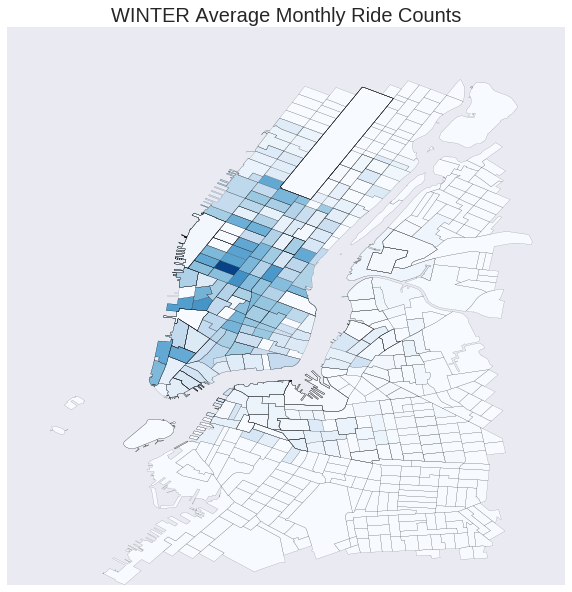

In [75]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAVGWinter_Zoom.plot(column='MonthlyAVGWinter',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("WINTER Average Monthly Ride Counts", fontsize=20)

### Export Shapefile CTs in the CitiBike Zone

In [46]:
path= 'Output/ct_shape_MonthlyAVGSummer_Zoom.shp'
ct_shape_MonthlyAVGSummer_Zoom.to_file(path)

In [47]:
path= 'Output/ct_shape_MonthlyAVGWinter_Zoom.shp'
ct_shape_MonthlyAVGWinter_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [48]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [49]:
# Index 10 neighbors
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [50]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [51]:
Wmatrix, ids = qW_CT.full()

In [52]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [53]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

### Summer & Winter Spatial Lag

In [56]:
MonthlyRideSUMMER = ct_shape_MonthlyAVGSummer_Zoom.MonthlyAVGSummer
MonthlyRideSUMMERLag = ps.lag_spatial(qW_CT, MonthlyRideSUMMER)

In [67]:
MonthlyRideWINTER = ct_shape_MonthlyAVGWinter_Zoom.MonthlyAVGWinter
MonthlyRideWINTERLag = ps.lag_spatial(qW_CT, MonthlyRideWINTER)

#### Create Quantiles for maping for Summer and Winter

In [66]:
MonthlyRideLagSUMMERQ10 = ps.Quantiles(MonthlyRideSUMMERLag, k=10)
MonthlyRideLagSUMMERQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   137.571                21
  137.571 < x[i] <=  2404.850                78
 2404.850 < x[i] <=  5510.364                80
 5510.364 < x[i] <= 11145.782                79
11145.782 < x[i] <= 16953.467                80
16953.467 < x[i] <= 36421.278                79
36421.278 < x[i] <= 52710.200                80
52710.200 < x[i] <= 61019.750                79
61019.750 < x[i] <= 94018.643                80

In [68]:
MonthlyRideLagWINTERQ10 = ps.Quantiles(MonthlyRideWINTERLag, k=10)
MonthlyRideLagWINTERQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=   100.000                 2
  100.000 < x[i] <=  1652.442                78
 1652.442 < x[i] <=  4131.471                80
 4131.471 < x[i] <=  6582.023                79
 6582.023 < x[i] <=  9880.056                80
 9880.056 < x[i] <= 21830.992                79
21830.992 < x[i] <= 29977.138                80
29977.138 < x[i] <= 35912.227                79
35912.227 < x[i] <= 57964.714                80

### Map the monthly rides lag: SUMMER

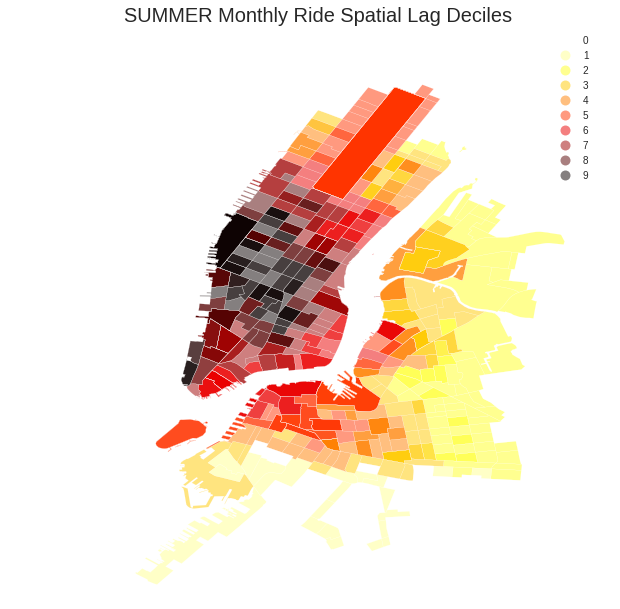

In [69]:
f, ax = plt.subplots(figsize=(10, 10))
ct_shape_MonthlyAVGSummer_Zoom.assign(cl=MonthlyRideLagSUMMERQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SUMMER Monthly Ride Spatial Lag Deciles", fontsize=20)


### Map the monthly rides lag: WINTER

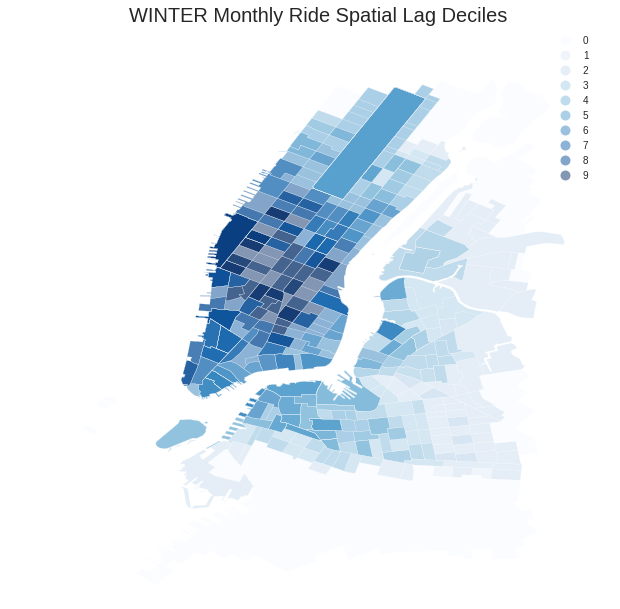

In [74]:
f, ax = plt.subplots(figsize=(10, 10))
ct_shape_MonthlyAVGWinter_Zoom.assign(cl=MonthlyRideLagWINTERQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='Blues', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WINTER Monthly Ride Spatial Lag Deciles", fontsize=20)

### this plot is not indictive of the rides in the Census Tracts, rather they are representative of the average of their "Queen Friends"


## Global  Spatial Autocorrelation

### SUMMER

In [77]:
b,a = np.polyfit(MonthlyRideSUMMER, MonthlyRideSUMMERLag, 1)
b,a 

(0.64466687635049424, 8128.844260081486)

### WINTER

In [78]:
b,a = np.polyfit(MonthlyRideWINTER, MonthlyRideWINTERLag, 1)
b,a

(0.65962241090192864, 4623.7815625116482)

### Moran's Scatterplot for Summer Months

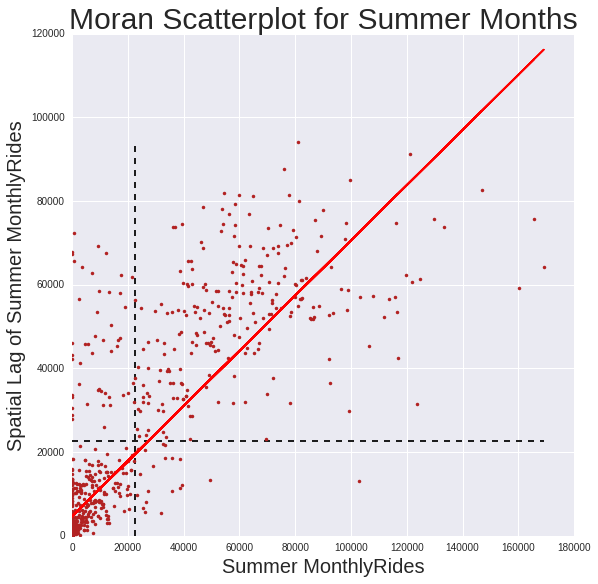

In [80]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRideSUMMER, MonthlyRideSUMMERLag, '.', color='firebrick')

 # dashed vertical at mean of the last year's PCI
plt.vlines(MonthlyRideSUMMER.mean(), MonthlyRideSUMMERLag.min(), MonthlyRideSUMMERLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideSUMMERLag.mean(), MonthlyRideSUMMER.min(), MonthlyRideSUMMER.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideSUMMER, a + b*MonthlyRideSUMMER, 'r')
plt.title('Moran Scatterplot for Summer Months', fontsize=30)
plt.ylabel('Spatial Lag of Summer MonthlyRides', fontsize=20)
plt.xlabel('Summer MonthlyRides', fontsize=20)

### Moran's Scatterplot for Winter Months

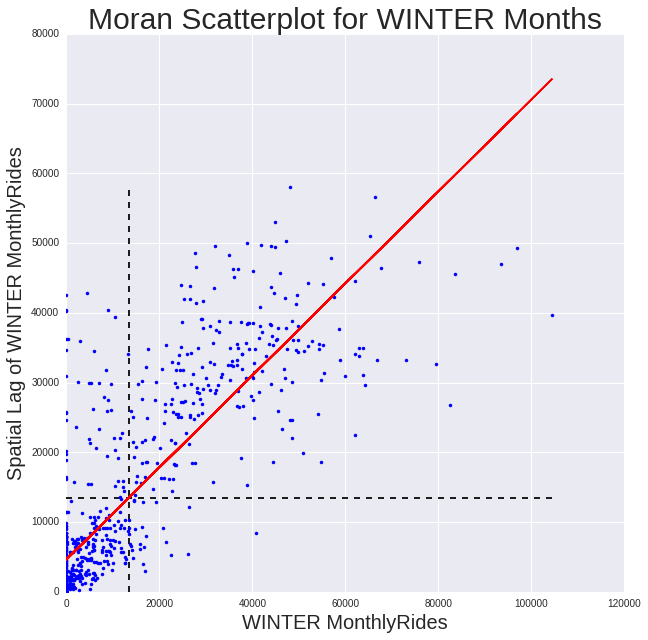

In [81]:
f, ax = plt.subplots(1, figsize=(10, 10))

plt.plot(MonthlyRideWINTER, MonthlyRideWINTERLag, '.', color='blue')

 # dashed vertical at mean of the last year's PCI
plt.vlines(MonthlyRideWINTER.mean(), MonthlyRideWINTERLag.min(), MonthlyRideWINTERLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideWINTERLag.mean(), MonthlyRideWINTER.min(), MonthlyRideWINTER.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideWINTER, a + b*MonthlyRideWINTER, 'r')
plt.title('Moran Scatterplot for WINTER Months', fontsize=30)
plt.ylabel('Spatial Lag of WINTER MonthlyRides', fontsize=20)
plt.xlabel('WINTER MonthlyRides', fontsize=20)

### Moran's I

In [82]:
I_SUMMERrides = ps.Moran(MonthlyRideSUMMER, qW_CT) # Summer Moran's i
I_WINTERrides = ps.Moran(MonthlyRideWINTER, qW_CT) # Winter Moran's i

In [84]:
print I_SUMMERrides.I, I_SUMMERrides.p_sim
print I_WINTERrides.I, I_WINTERrides.p_sim

0.644825188485 0.001
0.659777186107 0.001


This is the pvalue.. .001, shows how sigificant is this line, 
Thus, the $I$ statistic is $0.645$ for Summer and $0.659$ for Winter, both have very small $p$ value. 

In [86]:
print I_SUMMERrides.sim[0:10]
print I_WINTERrides.sim[0:10]

[ 0.02406007  0.00393525 -0.02877502 -0.00818298  0.0603958  -0.01662571
  0.01671963  0.01165198  0.00783455 -0.01405387]
[-0.01993173 -0.012429    0.01673513  0.01540913 -0.01995153  0.02366576
 -0.00833871  0.00441467  0.01412623  0.01970002]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [87]:
plt.rcParams['figure.figsize']=(14,3)

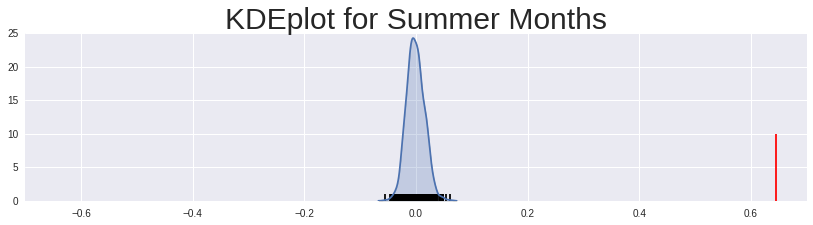

In [88]:
sns.kdeplot(I_SUMMERrides.sim, shade=True)
plt.vlines(I_SUMMERrides.sim, 0, 1)
plt.vlines(I_SUMMERrides.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Summer Months', fontsize=30)

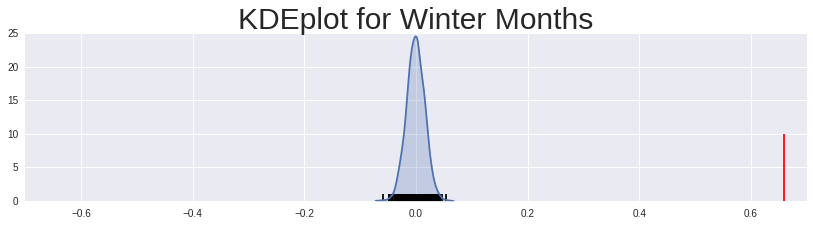

In [89]:
sns.kdeplot(I_WINTERrides.sim, shade=True)
plt.vlines(I_WINTERrides.sim, 0, 1)
plt.vlines(I_WINTERrides.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Winter Months', fontsize=30)

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

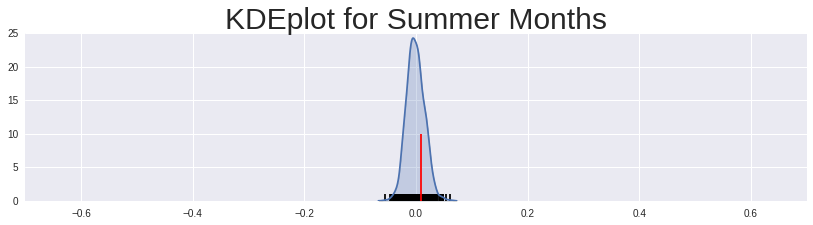

In [91]:
sns.kdeplot(I_SUMMERrides.sim, shade=True)
plt.vlines(I_SUMMERrides.sim, 0, 1)
plt.vlines(I_SUMMERrides.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Summer Months', fontsize=30)

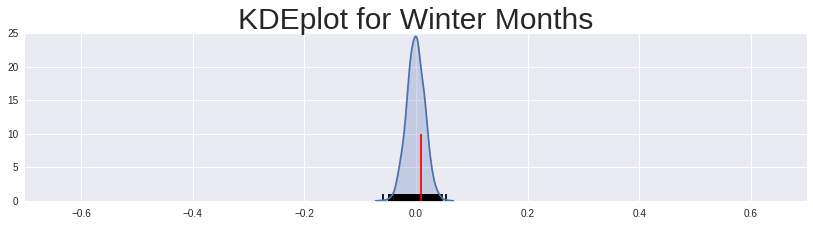

In [92]:
sns.kdeplot(I_WINTERrides.sim, shade=True)
plt.vlines(I_WINTERrides.sim, 0, 1)
plt.vlines(I_WINTERrides.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Winter Months', fontsize=30)

## Local  Spatial Autocorrelation

In [93]:
LMo_SUMMERrides = ps.Moran_Local(MonthlyRideSUMMER, qW_CT,permutations=999)
LMo_WINTERrides = ps.Moran_Local(MonthlyRideWINTER, qW_CT,permutations=999)

In [95]:
print LMo_SUMMERrides.Is[0:5], LMo_SUMMERrides.p_sim[0:5]
print LMo_WINTERrides.Is[0:5], LMo_WINTERrides.p_sim[0:5]

[-0.         -0.23934856  0.01170042  0.00166728  0.021779  ] [ 0.001  0.181  0.375  0.324  0.377]
[-0.         -0.27131052  0.000345   -0.00107098 -0.04975374] [ 0.001  0.169  0.455  0.499  0.435]


## LISA (Local Indicators of Spatial Autocorrelation)

### Summer LISA

In [98]:
SUMMER_sigs = MonthlyRideSUMMER[LMo_SUMMERrides.p_sim <= .001]
SUMMER_W_sigs = MonthlyRideSUMMERLag[LMo_SUMMERrides.p_sim <= .001]
SUMMER_insigs = MonthlyRideSUMMER[LMo_SUMMERrides.p_sim > .001]
SUMMER_W_insigs = MonthlyRideSUMMERLag[LMo_SUMMERrides.p_sim > .001]

### Winter LISA

In [99]:
WINTER_sigs = MonthlyRideWINTER[LMo_WINTERrides.p_sim <= .001]
WINTER_W_sigs = MonthlyRideWINTERLag[LMo_WINTERrides.p_sim <= .001]
WINTER_insigs = MonthlyRideWINTER[LMo_WINTERrides.p_sim > .001]
WINTER_W_insigs = MonthlyRideWINTERLag[LMo_WINTERrides.p_sim > .001]

### Plot Signficant SUMMER LISA

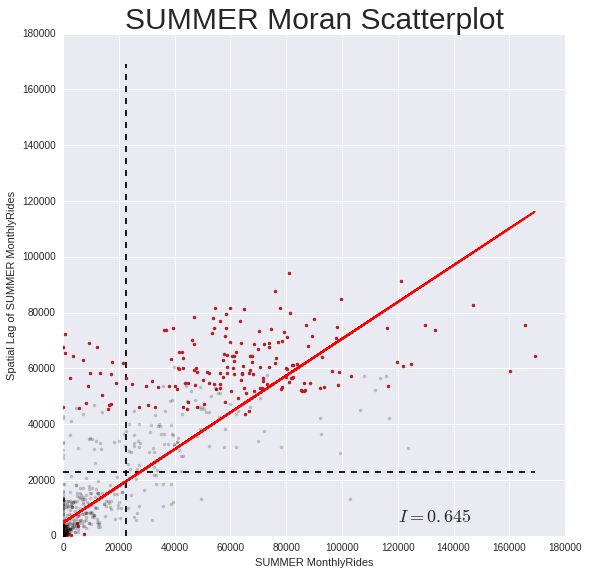

In [100]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(SUMMER_sigs, SUMMER_W_sigs, '.', color='firebrick')
plt.plot(SUMMER_insigs, SUMMER_W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SUMMERrides.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideSUMMER.mean(), MonthlyRideSUMMERLag.min(), MonthlyRideSUMMER.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideSUMMERLag.mean(), MonthlyRideSUMMER.min(), MonthlyRideSUMMER.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideSUMMER, a + b*MonthlyRideSUMMER, 'r')
plt.title('SUMMER Moran Scatterplot', fontsize=30)
plt.ylabel('Spatial Lag of SUMMER MonthlyRides')
plt.xlabel('SUMMER MonthlyRides')


# Plot Significant WINTER LISA

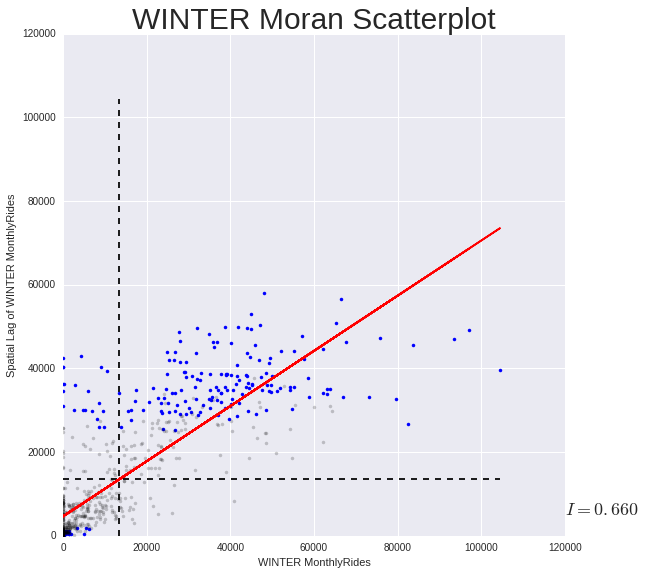

In [101]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(WINTER_sigs, WINTER_W_sigs, '.', color='blue')
plt.plot(WINTER_insigs, WINTER_W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WINTERrides.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideWINTER.mean(), MonthlyRideWINTERLag.min(), MonthlyRideWINTER.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideWINTERLag.mean(), MonthlyRideWINTER.min(), MonthlyRideWINTER.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideWINTER, a + b*MonthlyRideWINTER, 'r')
plt.title('WINTER Moran Scatterplot', fontsize=30)
plt.ylabel('Spatial Lag of WINTER MonthlyRides')
plt.xlabel('WINTER MonthlyRides')

## Hot and Cold spots: SUMMER

In [103]:
SUMMER_sigHC = LMo_SUMMERrides.p_sim < 0.01
hotspots = LMo_SUMMERrides.q==1 * SUMMER_sigHC
coldspots = LMo_SUMMERrides.q==3 * SUMMER_sigHC
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 188
Number of Coldspots: 240


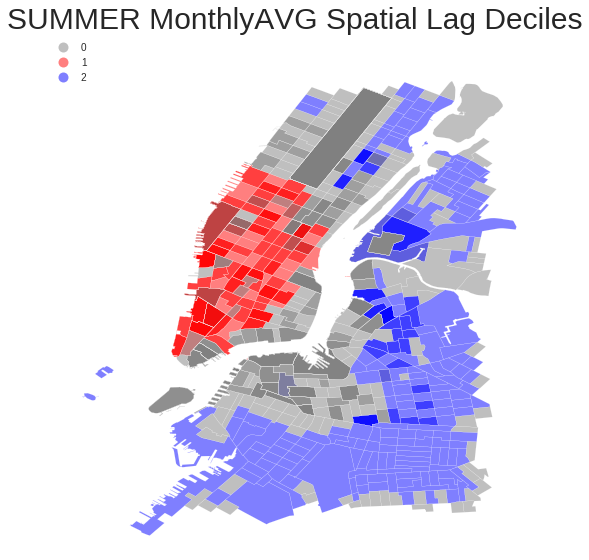

In [105]:
hcmap_SUMMER = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAVGSummer_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_SUMMER, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SUMMER MonthlyAVG Spatial Lag Deciles", fontsize=30)

## Hot and Cold spots: WINTER

In [106]:
WINTER_sigHC = LMo_SUMMERrides.p_sim < 0.01
hotspots = LMo_WINTERrides.q==1 * WINTER_sigHC
coldspots = LMo_WINTERrides.q==3 * WINTER_sigHC
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 190
Number of Coldspots: 239


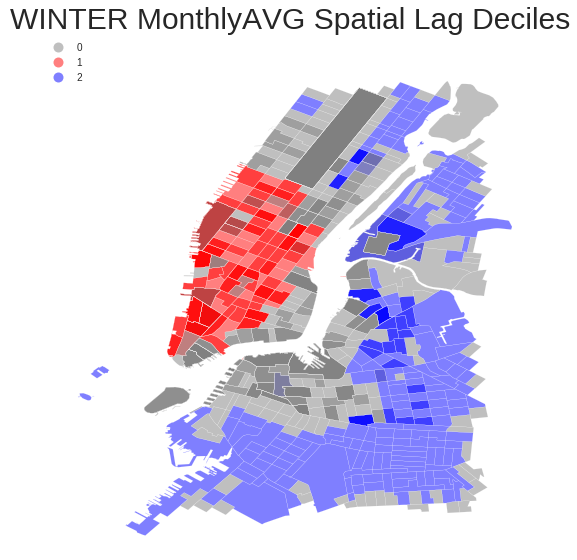

In [107]:
hcmap_WINTER = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAVGWinter_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_WINTER, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WINTER MonthlyAVG Spatial Lag Deciles", fontsize=30)